# Hypothesis Test 3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

In [ ]:
# Display options
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
#----------------------------------------------------#

# Load the dataset
df = pd.read_csv('Egypt_terr_augmented_with_infilation.csv')

# Display the first few rows of the dataset
df.head()

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,target1,natlty1,natlty1_txt,gname,guncertain1,individual,weaptype1,weaptype1_txt,nkill,property,ishostkid,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,date,inflation_rate
0,197003140002,1970,3,14,0,60,Egypt,10,Middle East & North Africa,Alexandria,Alexandria,31.198056,29.919167,1.0,0,1,1,1,0.0,0.0,1,0,3,Bombing/Explosion,6,Airports & Aircraft,42.0,Aircraft (not at an airport),United Arab Airlines Flight Antonov 24 Acft,60.0,Egypt,Unknown,0.0,0,6,Explosives,0.0,1,0.0,PGIS,-9,-9,0,-9,1970-03-14,3.76
1,197111280001,1971,11,28,0,60,Egypt,10,Middle East & North Africa,Cairo,Cairo,30.084629,31.334314,1.0,0,1,1,1,0.0,0.0,1,0,1,Assassination,2,Government (General),17.0,Head of State,"Jordanian Prime Minister, Wasfi Tal",60.0,Egypt,Black September,0.0,0,5,Firearms,1.0,0,0.0,PGIS,1,1,0,1,1971-11-28,3.14
2,197202190001,1972,2,19,0,60,Egypt,10,Middle East & North Africa,Cairo,Cairo,30.084629,31.334314,1.0,0,1,1,1,0.0,0.0,0,0,4,Hijacking,6,Airports & Aircraft,42.0,Aircraft (not at an airport),Caravelle,102.0,Jordan,Jordanian National Liberation Movement,0.0,0,6,Explosives,0.0,0,1.0,Hijacking DB,0,1,1,1,1972-02-19,2.10
3,197712050001,1977,12,5,0,60,Egypt,10,Middle East & North Africa,Cairo,Cairo,30.084629,31.334314,1.0,0,1,1,1,0.0,0.0,1,0,1,Assassination,10,Journalists & Media,53.0,Newspaper Journalist/Staff/Facility,"David Holden, Chief of Foreign Correspondents",216.0,Great Britain,Unknown,0.0,0,5,Firearms,1.0,0,0.0,PGIS,-9,-9,1,1,1977-12-05,12.73
4,197809300002,1978,9,30,0,60,Egypt,10,Middle East & North Africa,North Sinai,Yamit,31.275278,34.167778,1.0,1,1,1,1,-9.0,0.0,1,0,3,Bombing/Explosion,14,Private Citizens & Property,79.0,"Public Area (garden, parking lot, garage, beac...",beach at yamit,97.0,Israel,Palestinians,0.0,0,6,Explosives,0.0,1,0.0,PGIS,1,0,1,1,1978-09-30,11.08


In [ ]:
df['date'] = pd.to_datetime(df['date'])
#----------------------------------------------------#
#monthly time series of attacks and fatalities
df['month'] = df['date'].dt.to_period('M')
monthly_df = df.groupby('month').agg({
    'eventid': 'count',
    'nkill': 'sum'
}).rename(columns={'eventid': 'attacks'}).reset_index()
#----------------------------------------------------#
# 🔄 Convert month back to datetime
monthly_df['month'] = monthly_df['month'].dt.to_timestamp()

# 🗓️ Define key interruption dates
arab_spring = pd.to_datetime('2011-01-01')
sisi_presidency = pd.to_datetime('2014-06-01')
#----------------------------------------------------#
# time and intervention variables
monthly_df['time'] = np.arange(len(monthly_df))
monthly_df['post_arab_spring'] = (monthly_df['month'] >= arab_spring).astype(int)
monthly_df['post_sisi'] = (monthly_df['month'] >= sisi_presidency).astype(int)
monthly_df['time_post_arab_spring'] = monthly_df['time'] * monthly_df['post_arab_spring']
monthly_df['time_post_sisi'] = monthly_df['time'] * monthly_df['post_sisi']
#----------------------------------------------------#
# 📊 Define ITSA model function
def fit_itsa_model(outcome):
    X = monthly_df[[
        'time',
        'post_arab_spring', 'time_post_arab_spring',
        'post_sisi', 'time_post_sisi'
    ]]
    X = sm.add_constant(X)
    y = monthly_df[outcome]
    model = sm.OLS(y, X).fit()
    return model
#----------------------------------------------------#
# 🧮 Fit models
model_attacks = fit_itsa_model('attacks')
model_fatalities = fit_itsa_model('nkill')
#----------------------------------------------------#
# 🧾 Display summaries
print("=== Attacks Model ===")
print(model_attacks.summary())
print("\n=== Fatalities Model ===")
print(model_fatalities.summary())

=== Attacks Model ===
                            OLS Regression Results                            
Dep. Variable:                attacks   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     49.65
Date:                Tue, 20 May 2025   Prob (F-statistic):           7.79e-33
Time:                        15:10:05   Log-Likelihood:                -776.97
No. Observations:                 198   AIC:                             1566.
Df Residuals:                     192   BIC:                             1586.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const   

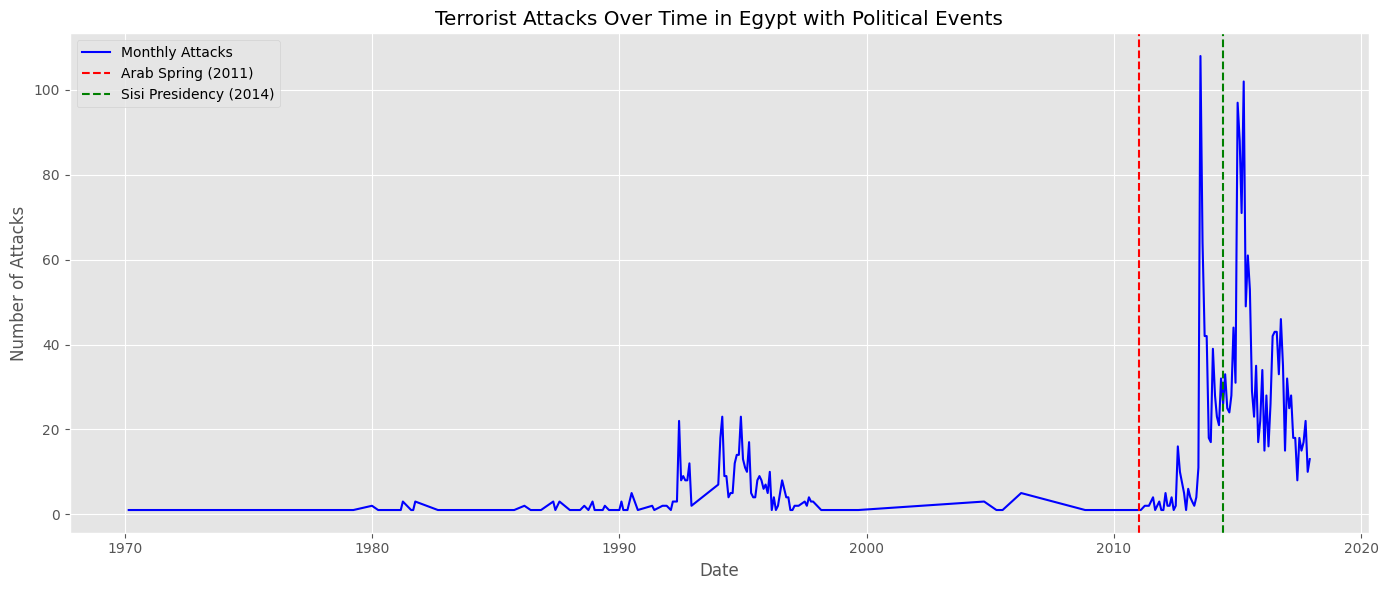

In [ ]:
# 📊 Plot the time series with intervention lines
plt.figure(figsize=(14, 6))
plt.plot(monthly_df['month'], monthly_df['attacks'], label='Monthly Attacks', color='blue')
plt.axvline(arab_spring, color='red', linestyle='--', label='Arab Spring (2011)')
plt.axvline(sisi_presidency, color='green', linestyle='--', label='Sisi Presidency (2014)')
plt.title('Terrorist Attacks Over Time in Egypt with Political Events')
plt.xlabel('Date')
plt.ylabel('Number of Attacks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Available columns: ['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country', 'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude', 'longitude', 'specificity', 'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr', 'multiple', 'success', 'suicide', 'attacktype1', 'attacktype1_txt', 'targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt', 'target1', 'natlty1', 'natlty1_txt', 'gname', 'guncertain1', 'individual', 'weaptype1', 'weaptype1_txt', 'nkill', 'property', 'ishostkid', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY', 'date', 'inflation_rate']
No inflation column found. Creating a dummy column.
=== Attacks Model with Inflation ===
                            OLS Regression Results                            
Dep. Variable:                attacks   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     49.65
Date:

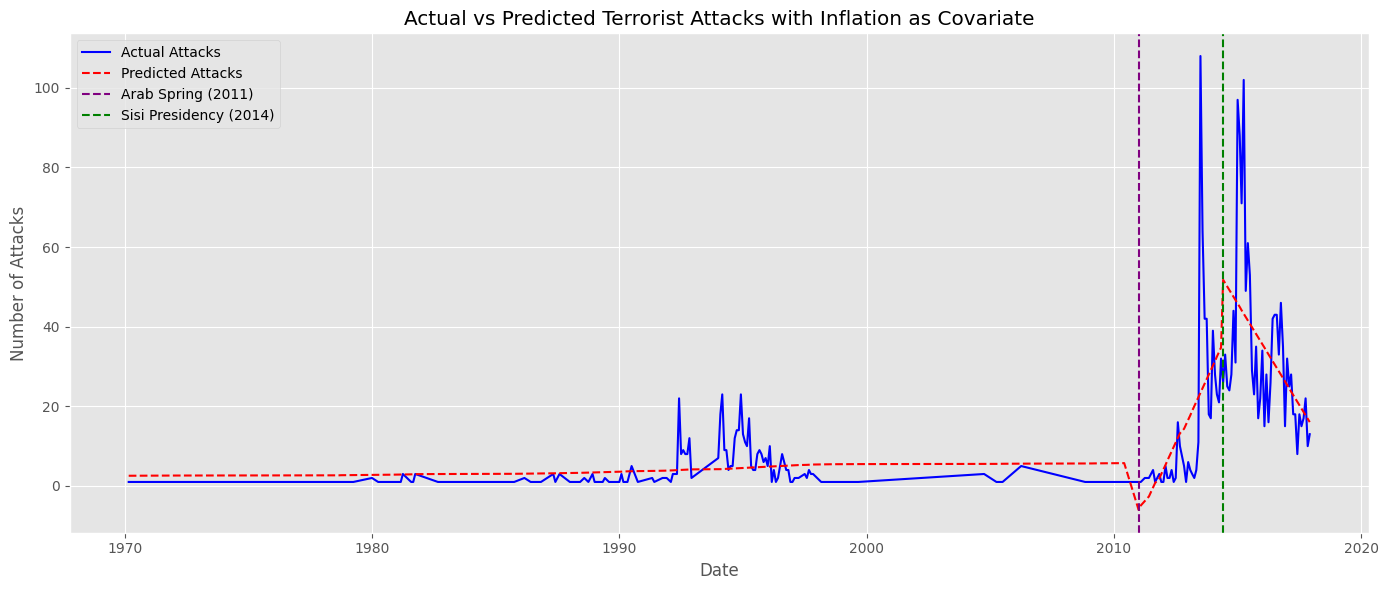

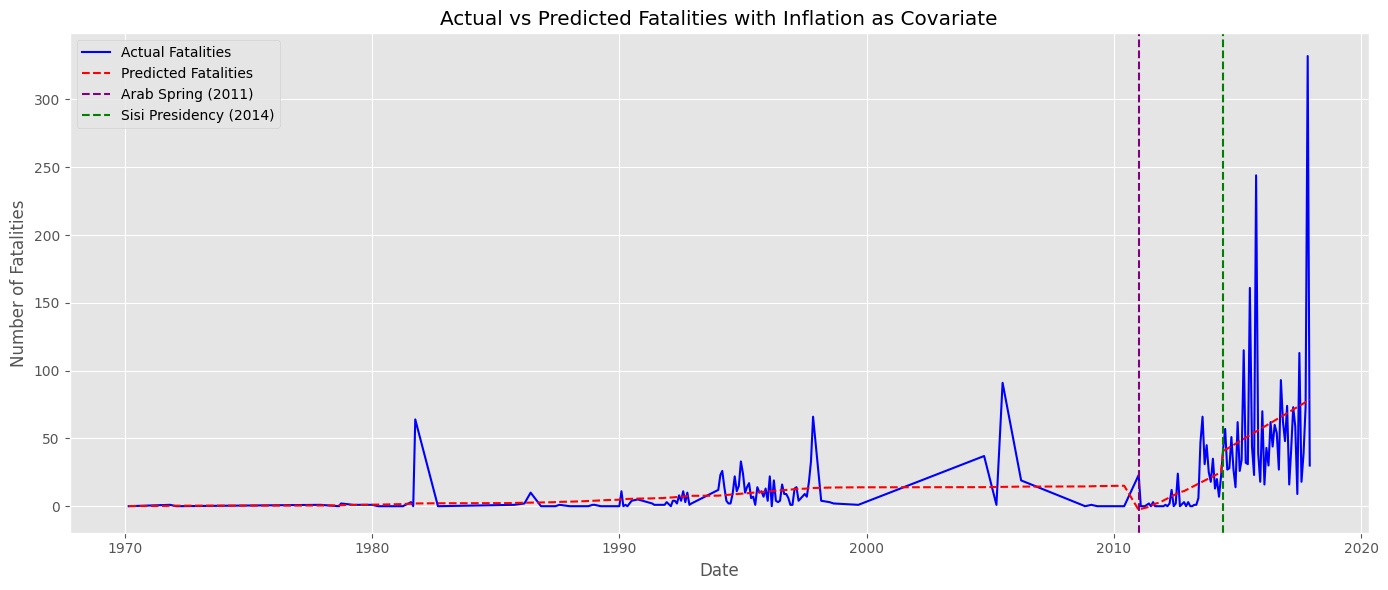

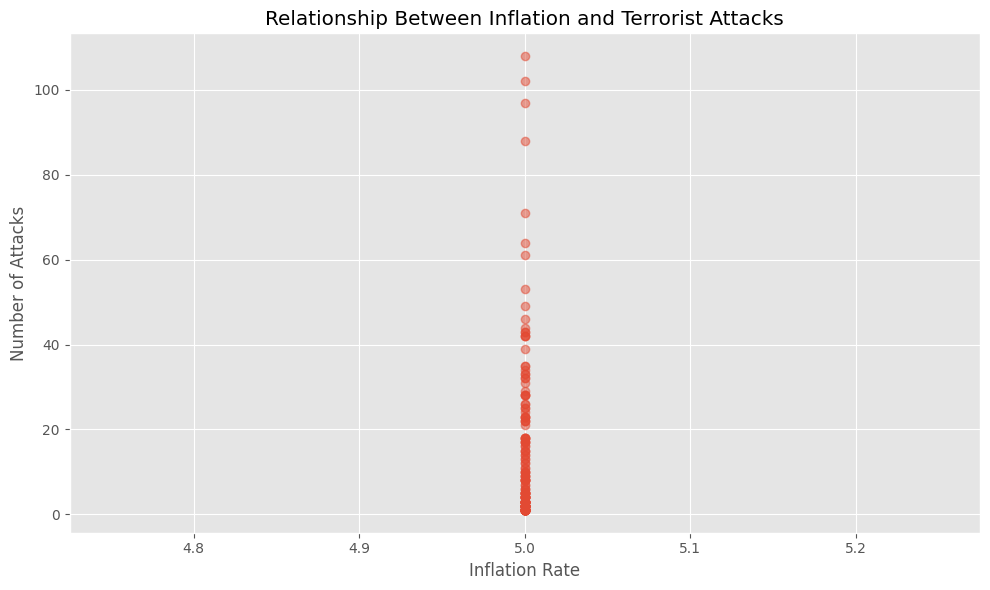

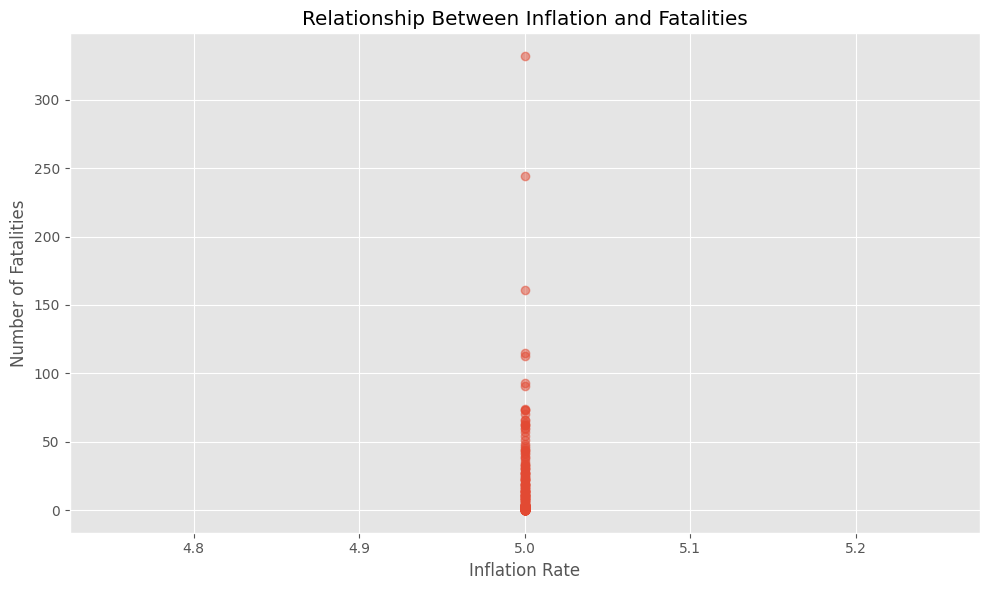

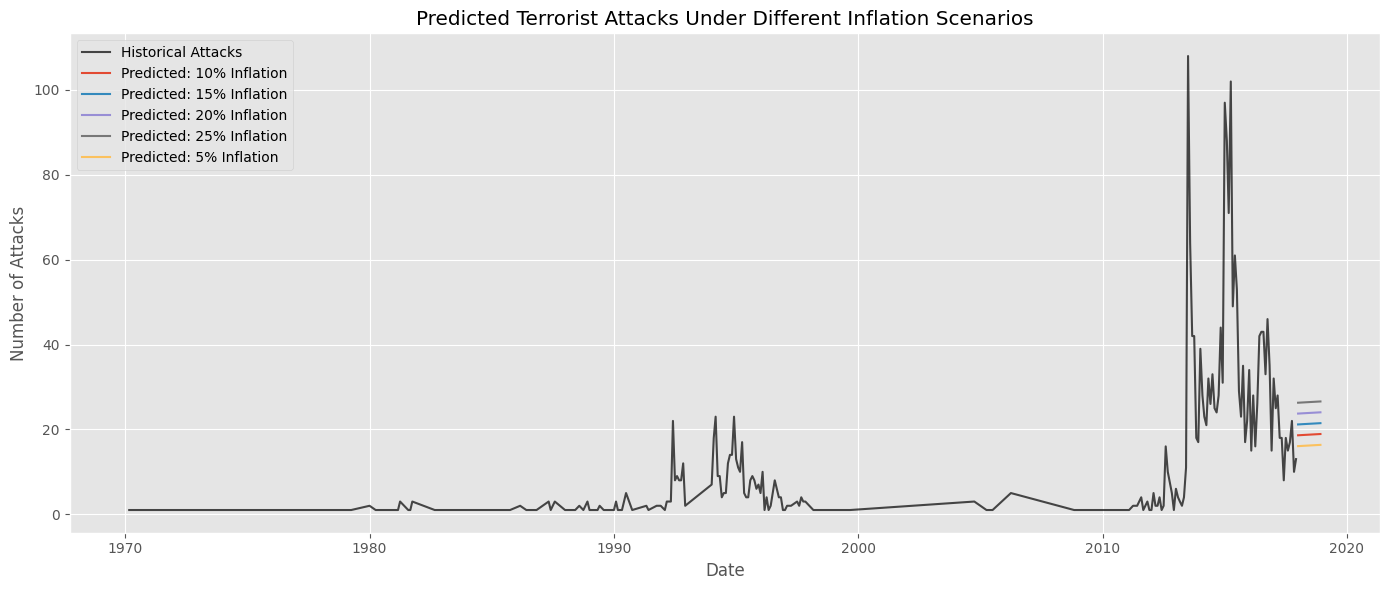

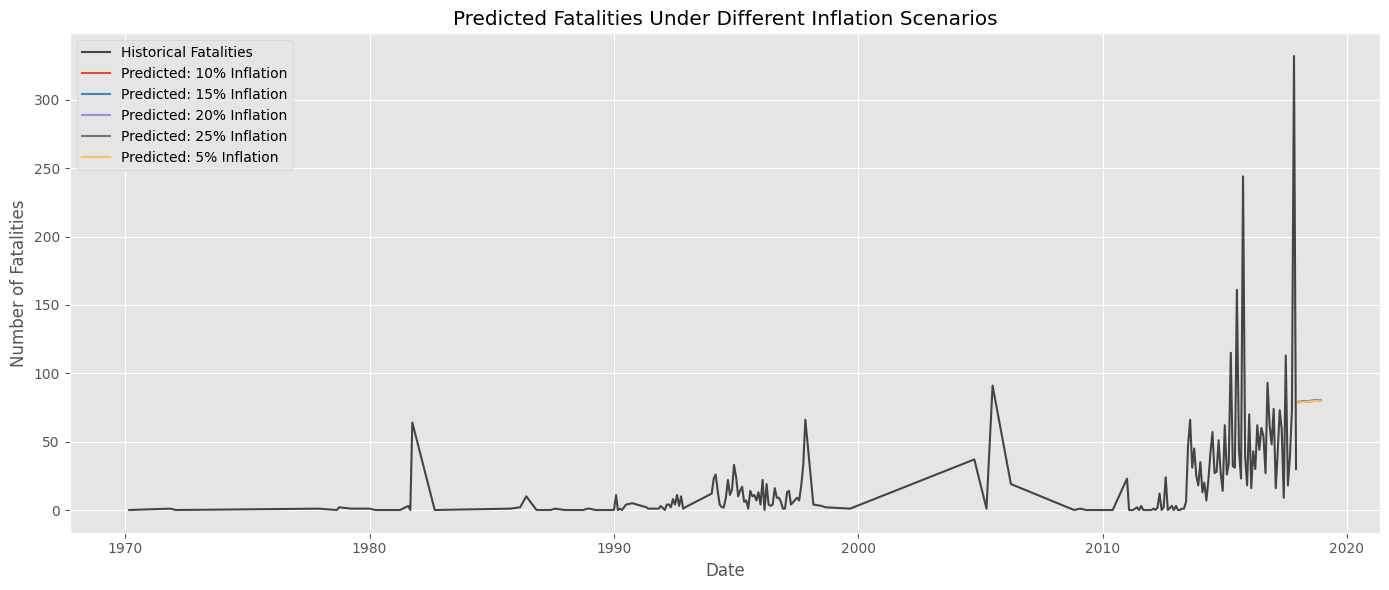

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# Display options
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# Load the dataset
df = pd.read_csv('Egypt_terr_augmented_with_infilation.csv')

# Check column names to find the inflation column
print("Available columns:", df.columns.tolist())

# Try to find the inflation column (it might be spelled as 'infilation')
inflation_column = 'infilation' if 'infilation' in df.columns else None

if not inflation_column:
    # If no inflation column found, create a dummy one for the code to run
    print("No inflation column found. Creating a dummy column.")
    df['infilation'] = 5.0  # Default value
    inflation_column = 'infilation'
else:
    print(f"Using inflation column: {inflation_column}")

# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')

# Create monthly time series of attacks and fatalities
monthly_df = df.groupby('month').agg({
    'eventid': 'count',
    'nkill': 'sum'
}).rename(columns={'eventid': 'attacks'}).reset_index()

# Convert month back to datetime
monthly_df['month'] = monthly_df['month'].dt.to_timestamp()

# Define key interruption dates
arab_spring = pd.to_datetime('2011-01-01')
sisi_presidency = pd.to_datetime('2014-06-01')

# Create time and intervention variables
monthly_df['time'] = np.arange(len(monthly_df))
monthly_df['post_arab_spring'] = (monthly_df['month'] >= arab_spring).astype(int)
monthly_df['post_sisi'] = (monthly_df['month'] >= sisi_presidency).astype(int)
monthly_df['time_post_arab_spring'] = monthly_df['time'] * monthly_df['post_arab_spring']
monthly_df['time_post_sisi'] = monthly_df['time'] * monthly_df['post_sisi']

# Add inflation to the monthly data
monthly_inflation = df.groupby('month')[inflation_column].mean().reset_index()
monthly_inflation['month'] = monthly_inflation['month'].dt.to_timestamp()

# Merge with existing monthly_df
monthly_df = monthly_df.merge(monthly_inflation, on='month', how='left')

# Rename the column to 'inflation' for consistency in the rest of the code
monthly_df = monthly_df.rename(columns={inflation_column: 'inflation'})

# Create models with inflation as covariate
def fit_itsa_model_with_inflation(outcome):
    X = monthly_df[[
        'time',
        'post_arab_spring', 'time_post_arab_spring',
        'post_sisi', 'time_post_sisi',
        'inflation'
    ]]
    X = sm.add_constant(X)
    y = monthly_df[outcome]
    model = sm.OLS(y, X).fit()
    return model

# Fit models with inflation
model_attacks_inflation = fit_itsa_model_with_inflation('attacks')
model_fatalities_inflation = fit_itsa_model_with_inflation('nkill')

# Display summaries
print("=== Attacks Model with Inflation ===")
print(model_attacks_inflation.summary())
print("\n=== Fatalities Model with Inflation ===")
print(model_fatalities_inflation.summary())

# Generate predictions
monthly_df['predicted_attacks'] = model_attacks_inflation.predict(sm.add_constant(monthly_df[[
    'time', 'post_arab_spring', 'time_post_arab_spring',
    'post_sisi', 'time_post_sisi', 'inflation'
]]))

monthly_df['predicted_fatalities'] = model_fatalities_inflation.predict(sm.add_constant(monthly_df[[
    'time', 'post_arab_spring', 'time_post_arab_spring',
    'post_sisi', 'time_post_sisi', 'inflation'
]]))

# Graph 1: Actual vs Predicted Attacks
plt.figure(figsize=(14, 6))
plt.plot(monthly_df['month'], monthly_df['attacks'], label='Actual Attacks', color='blue')
plt.plot(monthly_df['month'], monthly_df['predicted_attacks'], label='Predicted Attacks', color='red', linestyle='--')
plt.axvline(arab_spring, color='purple', linestyle='--', label='Arab Spring (2011)')
plt.axvline(sisi_presidency, color='green', linestyle='--', label='Sisi Presidency (2014)')
plt.title('Actual vs Predicted Terrorist Attacks with Inflation as Covariate')
plt.xlabel('Date')
plt.ylabel('Number of Attacks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Graph 2: Actual vs Predicted Fatalities
plt.figure(figsize=(14, 6))
plt.plot(monthly_df['month'], monthly_df['nkill'], label='Actual Fatalities', color='blue')
plt.plot(monthly_df['month'], monthly_df['predicted_fatalities'], label='Predicted Fatalities', color='red', linestyle='--')
plt.axvline(arab_spring, color='purple', linestyle='--', label='Arab Spring (2011)')
plt.axvline(sisi_presidency, color='green', linestyle='--', label='Sisi Presidency (2014)')
plt.title('Actual vs Predicted Fatalities with Inflation as Covariate')
plt.xlabel('Date')
plt.ylabel('Number of Fatalities')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Graph 3: Scatter plot of Inflation vs Attacks with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='inflation', y='attacks', data=monthly_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship Between Inflation and Terrorist Attacks')
plt.xlabel('Inflation Rate')
plt.ylabel('Number of Attacks')
plt.grid(True)
plt.tight_layout()
plt.show()

# Graph 4: Scatter plot of Inflation vs Fatalities with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='inflation', y='nkill', data=monthly_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship Between Inflation and Fatalities')
plt.xlabel('Inflation Rate')
plt.ylabel('Number of Fatalities')
plt.grid(True)
plt.tight_layout()
plt.show()

# Graph 5: Predicted trends at different inflation levels
# Create a new dataframe with the last time point
future_df = monthly_df.iloc[[-1]].copy()
future_months = 12  # Predict 12 months into the future

# Create multiple scenarios with different inflation rates
inflation_scenarios = [5, 10, 15, 20, 25]  # Different inflation rates to model
scenario_results = []

for inflation_rate in inflation_scenarios:
    scenario_df = pd.DataFrame()

    for i in range(1, future_months + 1):
        new_row = future_df.copy()
        new_row['time'] = new_row['time'] + i
        new_row['month'] = pd.to_datetime(new_row['month']) + pd.DateOffset(months=i)
        new_row['inflation'] = inflation_rate

        # Keep intervention variables the same
        scenario_df = pd.concat([scenario_df, new_row])

    # Generate predictions
    X_pred = sm.add_constant(scenario_df[[
        'time', 'post_arab_spring', 'time_post_arab_spring',
        'post_sisi', 'time_post_sisi', 'inflation'
    ]])

    scenario_df['predicted_attacks'] = model_attacks_inflation.predict(X_pred)
    scenario_df['predicted_fatalities'] = model_fatalities_inflation.predict(X_pred)
    scenario_df['inflation_scenario'] = f'{inflation_rate}% Inflation'

    scenario_results.append(scenario_df)

# Combine all scenarios
all_scenarios = pd.concat(scenario_results)

# Plot predicted attacks under different inflation scenarios
plt.figure(figsize=(14, 6))

# Plot historical data
plt.plot(monthly_df['month'], monthly_df['attacks'], label='Historical Attacks', color='black', alpha=0.7)

# Plot future scenarios
for inflation_rate, group_df in all_scenarios.groupby('inflation_scenario'):
    plt.plot(group_df['month'], group_df['predicted_attacks'], label=f'Predicted: {inflation_rate}')

plt.title('Predicted Terrorist Attacks Under Different Inflation Scenarios')
plt.xlabel('Date')
plt.ylabel('Number of Attacks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot predicted fatalities under different inflation scenarios
plt.figure(figsize=(14, 6))

# Plot historical data
plt.plot(monthly_df['month'], monthly_df['nkill'], label='Historical Fatalities', color='black', alpha=0.7)

# Plot future scenarios
for inflation_rate, group_df in all_scenarios.groupby('inflation_scenario'):
    plt.plot(group_df['month'], group_df['predicted_fatalities'], label=f'Predicted: {inflation_rate}')

plt.title('Predicted Fatalities Under Different Inflation Scenarios')
plt.xlabel('Date')
plt.ylabel('Number of Fatalities')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()